# Third Flair Convnet  - Deep 
Build and train a ConvNet in TensorFlow for a segmentation problem
net trained with data from Brats2017:

* Flair images
* Tumor masks

** Capabilities **
* Has mini_batch parcelation
* Has tensorboard support
* creates txt summary
* multiple cost and accuray functions



## 0. Setup

*First*, make sure the GPU are avaible to run. Use `nvidia-smi` -l 1 to check usage and select the correct GPUs.
<br>
*Second*, run the following cell selecting the GPUs

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
#print (device_lib.list_local_devices())

import warnings
warnings.filterwarnings('ignore')

*Third*, import the libraries needed

In [12]:
import numpy as np
import random
import os
import nibabel as nib
import matplotlib.pyplot as plt
import time
from time import sleep 

import tensorflow as tf
from tensorflow.python.framework import ops # to use default graph
import h5py # to load data set
import math # for minibatches
from datetime import datetime # to create logs

#%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Import Data

The data is loaded from the folder:
<br>
> /data/Brats17TrainingData/Flair_HGG/flair.nii.gz
<br>
> /data/Brats17TrainingData/Flair_HGG/seg.nii.gz

The size of the images is [240x240x155] and there are 208 Nifti files. Therefore the total number of images is 32240.

Labels in the seg files are:
> Label 1: necrotic and non-enhancing tumor 
<br> Label 2: edema 
<br> Label 4: enhancing tumor
<br> Label 0: background


All label were simplified to 1 before creating the hdf5 files. Anything not background will be segemented as tumor.

The python notebook **h5_Brats_data_notebook** creates h5py files for the test and train datasets. Detail step-by-step explanation of the functions used. 
<br>
In this notebook, we load those files:
* flair_dataset.hdf5
* flair_masks.hdf5

In [13]:
hdf5_data_path = "data/datafloat32/flair_dataset.hdf5"  # address to save the hdf5 file
hdf5_mask_path = "data/datafloat32/flair_masks.hdf5"  # address to save the hdf5 file

# open the hdf5 file
hdf5_data_file = h5py.File(hdf5_data_path, "r")
# Total number of samples
print("train_data shape: " + str(hdf5_data_file["train_data"].shape) + str(hdf5_data_file["train_data"].dtype))
print("test_data shape: " + str(hdf5_data_file["test_data"].shape) + str(hdf5_data_file["test_data"].dtype))

# open the hdf5 file
hdf5_mask_file = h5py.File(hdf5_mask_path, "r")
# Total number of samples
print("train_mask shape: " + str(hdf5_mask_file["train_mask"].shape)+ str(hdf5_mask_file["train_mask"].dtype))
print("test_mask shape: " + str(hdf5_mask_file["test_mask"].shape)+ str(hdf5_mask_file["test_mask"].dtype))


train_data shape: (31000, 240, 240, 1)float32
test_data shape: (1240, 240, 240, 1)float32
train_mask shape: (31000, 240, 240, 2)float32
test_mask shape: (1240, 240, 240, 2)float32


<IPython.core.display.Javascript object>


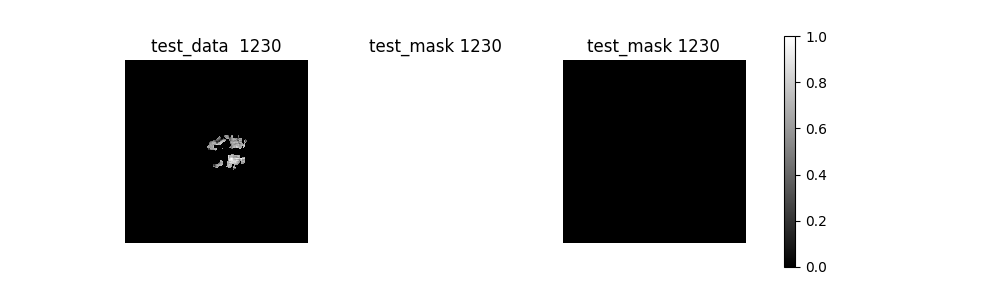

In [14]:
###======================== SHOW DATA ===================================###
%matplotlib notebook 
fig, ax = plt.subplots(ncols = 3, figsize=(10,3))

data_name = "test_data"
mask_name = "test_mask"
#data_name = "train_data"
#mask_name = "train_mask"

img3 = ax[2].imshow(hdf5_mask_file[mask_name][0,:,:,1], vmin=0, vmax=1, cmap=plt.get_cmap('gray'))
plt.colorbar(img3, ax=ax)

for h in range(0, hdf5_data_file[data_name].shape[0], 10):
    img1 = ax[0].imshow(hdf5_data_file[data_name][h,:,:,0], vmin=0, vmax=1, cmap=plt.get_cmap('gray'))
    ax[0].set_title(data_name + "  " + str(h))
    ax[0].axis('off')
    
    img2 = ax[1].imshow(hdf5_mask_file[mask_name][h,:,:,0], vmin=0, vmax=1, cmap=plt.get_cmap('gray'))
    ax[1].set_title(mask_name + " "  + str(h))
    ax[1].axis('off')
        
    img3 = ax[2].imshow(hdf5_mask_file[mask_name][h,:,:,1], vmin=0, vmax=1, cmap=plt.get_cmap('gray'))
    ax[2].set_title(mask_name + " "  + str(h))
    ax[2].axis('off')
    #plt.show()
    fig.canvas.draw()
    
    sleep(0.1)


## 2 .  Create placeholders

TensorFlow requires that placeholders to be created for the input data that will be fed into the model when running the session. [tf.placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

The function below to create placeholders for the input image X and the output Y. We do not define the number of training examples (use "None" as the batch size), it will give you the flexibility to choose it later. Hence:
* X should be of dimension **[None, n_H, n_W, 1]** 
* Y should be of dimension **[None, n_H, n_W, 2]**.  



In [15]:
def create_placeholders(n_H, n_W, batch_size):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H - scalar, height of an input image
    n_W - scalar, width of an input image
        
    Returns:
    X - placeholder for the data input, of shape [None, n_H, n_W, 1] and dtype "float"
    Y - placeholder for the input labels, of shape [None, n_H, n_W, 2] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=(batch_size, n_H, n_W, 1), name = 'X_placeholder')
    Y = tf.placeholder(tf.float32, shape=(batch_size, n_H, n_W, 2), name = 'Y_placeholder')
    train_flag = tf.placeholder(tf.bool, name='train_flag')
    
    
    return X, Y, train_flag

## 3.  Initialize parameters

```python
initialize_parameters() 
```
initializes weights/filters $W1$ and $W2$ using `tf.contrib.layers.xavier_initializer(seed = 0)`. No need to worry about bias variables, TensorFlow functions take care of the bias. Note also that you will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part 

In [16]:
def initialize_parameters(patch_size, num_channels, num_labels, img_size,
                          depth_1, depth_2, depth_3, depth_4 
                          ):
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W_conv1 : [patch_size, patch_size, num_channels, depth_1]
                        W_conv2 : [patch_size, patch_size,      depth_1, depth_2]
                        W_conv3 : [patch_size, patch_size,      depth_2, depth_3]
                        W_conv4 : [patch_size, patch_size,      depth_3, depth_4]
                        
                        W_deconv1 : [patch_size, patch_size, num_labels, depth_1]
                        W_deconv2 : [patch_size, patch_size,    depth_1, depth_2]
                        W_deconv3 : [patch_size, patch_size,    depth_2, depth_3]
                        W_deconv4 : [patch_size, patch_size,    depth_3, depth_4]
                        
    Arguments:
    patch_size   -
    num_channels -
    num_labels   -
    depth_1 -
    depth_2 -
    depth_3 -
    depth_4 -
    batch_size -
    image_size -
    
    Returns:
    parameters -- a dictionary of tensors containing W_conv1, W2
    """
    
    # with extra layer
    W_conv10 = tf.get_variable("W_conv10", [patch_size, patch_size, num_channels, depth_1], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_conv20 = tf.get_variable("W_conv20", [patch_size, patch_size,      depth_1, depth_2], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_conv30 = tf.get_variable("W_conv30", [patch_size, patch_size,      depth_2, depth_3], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_conv40 = tf.get_variable("W_conv40", [patch_size, patch_size,      depth_3, depth_4], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    
    W_conv1 = tf.get_variable("W_conv1", [patch_size, patch_size,  depth_1, depth_1], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_conv2 = tf.get_variable("W_conv2", [patch_size, patch_size,  depth_2, depth_2], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_conv3 = tf.get_variable("W_conv3", [patch_size, patch_size,  depth_3, depth_3], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_conv4 = tf.get_variable("W_conv4", [patch_size, patch_size,  depth_4, depth_4], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    
    W_deconv1 = tf.get_variable("W_deconv1", [patch_size, patch_size, num_labels, depth_1], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_deconv2 = tf.get_variable("W_deconv2", [patch_size, patch_size,    depth_1, depth_2], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_deconv3 = tf.get_variable("W_deconv3", [patch_size, patch_size,    depth_2, depth_3], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_deconv4 = tf.get_variable("W_deconv4", [patch_size, patch_size,    depth_3, depth_4], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    
    W_deconv10 = tf.get_variable("W_deconv10", [patch_size, patch_size, num_labels, num_labels], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_deconv20 = tf.get_variable("W_deconv20", [patch_size, patch_size, depth_1, depth_1], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_deconv30 = tf.get_variable("W_deconv30", [patch_size, patch_size, depth_2, depth_2], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_deconv40 = tf.get_variable("W_deconv40", [patch_size, patch_size, depth_3, depth_3], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
   
    W_fullA = tf.get_variable("W_fullA", [patch_size, patch_size, depth_4, depth_4] , initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_fullB = tf.get_variable("W_fullB", [patch_size, patch_size, depth_4, depth_4] , initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W_fullC = tf.get_variable("W_fullC", [patch_size, patch_size, depth_4, depth_4] , initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    

    parameters = {"W_conv10": W_conv10,
                  "W_conv20": W_conv20,
                  "W_conv30": W_conv30,
                  "W_conv40": W_conv40,
                  
                  "W_conv1": W_conv1,
                  "W_conv2": W_conv2,
                  "W_conv3": W_conv3,
                  "W_conv4": W_conv4,

                  "W_deconv1": W_deconv1,
                  "W_deconv2": W_deconv2,
                  "W_deconv3": W_deconv3,
                  "W_deconv4": W_deconv4,
                  
                  "W_deconv10": W_deconv10,
                  "W_deconv20": W_deconv20,
                  "W_deconv30": W_deconv30,
                  "W_deconv40": W_deconv40,
                  
                  "W_fullA" : W_fullA,
                  "W_fullB" : W_fullB,
                  "W_fullC" : W_fullC

                 }

    
    return parameters

## 4. Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps for you.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters. 


The `forward_propagation` function below to build the following model: 

In [26]:
def forward_propagation(X, parameters, train_flag, mode = "train", keep_prob = 0.7):
    """
    Implements the forward propagation for the model:
    
    Conv2D    Conv2D     Conv2D     Conv2D     Conv2D    Conv2D     Conv2D    Conv2D     
    ReLU  -->  ReLU  -->  ReLU  -->  ReLU  --> ReLU  -->  ReLU  --> ReLU  -->  ReLU  --| 
    (s1)       (s2)       (s1)       (s2)      (s1)       (s2)      (s1)       (s2)    |    
    \______________/     \______________/     \______________/     \______________/    |
            |                    |                    |                    |           Conv2D ReLU (s1) | Fully Conn A
          CONV1                CONV2                CONV3                CONV4         Conv2D ReLU (s1) | Fully Conn B
                                                                                       Conv2D ReLU (s1) | Fully Conn C
    Conv2D    TConv2D    Conv2D    TConv2D    Conv2D    TConv2D    Conv2D    TConv2D   |     
    ReLU  <--  ReLU  <--  ReLU  <--  ReLU  <-- ReLU  <--  ReLU  <-- ReLU  <--  ReLU  <-| 
    (s1)       (s2)       (s1)       (s2)      (s1)       (s2)      (s1)       (s2)        
    \______________/     \______________/     \______________/     \______________/   
            |                    |                    |                    |
          DeCONV1             DeCONV2              DeCONV3              DeCONV4
    
    
    Arguments:
    X - input dataset placeholder, of shape (input size, number of examples)
    parameters - python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters
    mode -
    keep_prod - probability for dropout (only on mode "train")

    Returns:
    dA1 - the output of the last deconv unit
    """
    if ( mode == 'train'): print(" --------- Net --------- ")
    
    # Retrieve the parameters from the dictionary "parameters"     
    W_conv10 = parameters["W_conv10"]
    W_conv20 = parameters["W_conv20"]
    W_conv30 = parameters["W_conv30"]
    W_conv40 = parameters["W_conv40"]
    
    W_conv1 = parameters["W_conv1"]
    W_conv2 = parameters["W_conv2"]
    W_conv3 = parameters["W_conv3"]
    W_conv4 = parameters["W_conv4"]    

    W_deconv1 = parameters["W_deconv1"]
    W_deconv2 = parameters["W_deconv2"]
    W_deconv3 = parameters["W_deconv3"]
    W_deconv4 = parameters["W_deconv4"]
    
    W_deconv10 = parameters["W_deconv10"]
    W_deconv20 = parameters["W_deconv20"]
    W_deconv30 = parameters["W_deconv30"]
    W_deconv40 = parameters["W_deconv40"]
    
    W_fullA = parameters["W_fullA"]
    W_fullB = parameters["W_fullB"]
    W_fullC = parameters["W_fullC"]
    
    
    # Convolutional Layer 1
    with tf.variable_scope('CONV1'):
        Z10 = tf.nn.conv2d(X, W_conv10, strides = [1, 1, 1, 1], padding='SAME', name = 'S1/conv2d')
        #Z10 = tf.contrib.layers.batch_norm(Z10, center=True, scale=True, is_training = train_flag)
        A10 = tf.nn.relu(Z10, name = 'S1/ReLU')   
        Z1 = tf.nn.conv2d(A10, W_conv1, strides = [1, 2, 2, 1], padding='SAME', name = 'S2/conv2d')
        A1 = tf.nn.relu(Z1, name = 'S2/ReLU')
        # MAXPOOL
        #P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,1,1,1], padding = 'SAME', name = 'S2/MAXPOOL')
        if ( mode == 'train'): print("Convolutional Layer 1 S1 " + str(A10.get_shape()))
        if ( mode == 'train'): print("Convolutional Layer 1 S2 " + str(A1.get_shape()))
    
    # Convolutional Layer 2
    with tf.variable_scope('CONV2'):
        Z20 = tf.nn.conv2d(A1, W_conv20, strides = [1, 1, 1, 1], padding='SAME', name = 'S1/conv2d')
        A20 = tf.nn.relu(Z20, name = 'S1/ReLU')
        Z2 = tf.nn.conv2d(A20, W_conv2, strides = [1, 2, 2, 1], padding='SAME', name = 'S2/conv2d')
        A2 = tf.nn.relu(Z2, name = 'S2/ReLU')
        # MAXPOOL
        #P2 = tf.nn.max_pool(A2, ksize = [1,6,6,1], strides = [1,1,1,1], padding = 'SAME', name = 'S2/MAXPOOL')
        if ( mode == 'train'): print("Convolutional Layer 2 S1 " + str(A20.get_shape()))
        if ( mode == 'train'): print("Convolutional Layer 2 S2 " + str(A2.get_shape()))
    
    # Convolutional Layer 3
    with tf.variable_scope('CONV3'):
        Z30 = tf.nn.conv2d(A2, W_conv30, strides = [1, 1, 1, 1], padding='SAME', name = 'S1/conv2d')
        A30 = tf.nn.relu(Z30, name = 'S1/ReLU')
        Z3 = tf.nn.conv2d(A30, W_conv3, strides = [1, 2, 2, 1], padding='SAME', name = 'S2/conv2d')
        A3 = tf.nn.relu(Z3, name = 'S2/ReLU')
        # MAXPOOL
        #P3 = tf.nn.max_pool(A3, ksize = [1,4,4,1], strides = [1,1,1,1], padding = 'SAME', name = 'S2/MAXPOOL')
        if ( mode == 'train'): print("Convolutional Layer 3 S1 " + str(A30.get_shape()))
        if ( mode == 'train'): print("Convolutional Layer 3 S2 " + str(A3.get_shape()))
        
    # Convolutional Layer 4
    with tf.variable_scope('CONV4'):
        Z40 = tf.nn.conv2d(A3, W_conv40, strides = [1, 1, 1, 1], padding='SAME', name = 'S1/conv2d')
        A40 = tf.nn.relu(Z40, name = 'S1/ReLU')
        Z4 = tf.nn.conv2d(A40, W_conv4, strides = [1, 2, 2, 1], padding='SAME', name = 'S2/conv2d')
        A4 = tf.nn.relu(Z4, name = 'S2/ReLU')
        # MAXPOOL
        #P4 = tf.nn.max_pool(A4, ksize = [1,2,2,1], strides = [1,1,1,1], padding = 'SAME', name = 'S2/MAXPOOL')
        if ( mode == 'train'): print("Convolutional Layer 4 S1 " + str(A40.get_shape()))
        if ( mode == 'train'): print("Convolutional Layer 4 S2 " + str(A4.get_shape()))
    
    if True: 
        # Fully Connected Layer A with Dropout
        with tf.variable_scope('FullyConnA'):
            if ( mode == 'train'):            
                A4 = tf.nn.dropout(A4,keep_prob)
            fZA = tf.nn.conv2d(A4, W_fullA, strides = [1, 1, 1, 1], padding='SAME')
            fAA = tf.nn.relu(fZA)
            if ( mode == 'train'): print("Fully Connected Layer A " + str(fAA.get_shape()))
        
        # Fully Connected Layer B with Dropout
        with tf.variable_scope('FullyConnB'):
            if ( mode == 'train'):            
                fAA = tf.nn.dropout(fAA,keep_prob)
            fZB = tf.nn.conv2d(fAA, W_fullB, strides = [1, 1, 1, 1], padding='SAME')
            fAB = tf.nn.relu(fZB)
            if ( mode == 'train'): print("Fully Connected Layer B " + str(fAB.get_shape()))
        
        # Fully Connected Layer C with Dropout
        with tf.variable_scope('FullyConnC'):
            if ( mode == 'train'):            
                fAB = tf.nn.dropout(fAB,keep_prob)
            fZC = tf.nn.conv2d(fAB, W_fullC, strides = [1, 1, 1, 1], padding='SAME')
            fAC = tf.nn.relu(fZC )
            if ( mode == 'train'): print("Fully Connected Layer C " + str(fAC.get_shape()))
    
    # DEConvolutional Layer 4
    with tf.variable_scope('DeCONV4'):
        dZ4 = tf.nn.conv2d_transpose(fAC, W_deconv4, A3.get_shape(), strides = [1, 2, 2, 1], padding='SAME', name = 'S2/conv2d_transpose')
        dA4 = tf.nn.relu(tf.add_n([dZ4 , Z3])) #
        dZ40 = tf.nn.conv2d(dA4, W_deconv40, strides = [1, 1, 1, 1], padding='SAME', name = 'S1/conv2d')
        dA40 = tf.nn.relu(dZ40, name = 'S2/ReLU')
        # MAXPOOL
        #dP4 = tf.nn.max_pool(dA4, ksize = [1,2,2,1], strides = [1,1,1,1], padding = 'SAME')
        if ( mode == 'train'): print("Deconvolutional Layer 4 S2 " + str(dA4.get_shape()))
        if ( mode == 'train'): print("Deconvolutional Layer 4 S1 " + str(dA40.get_shape()))
        
    # DEConvolutional Layer 3
    with tf.variable_scope('DeCONV3'):
        dZ3 = tf.nn.conv2d_transpose(dA40, W_deconv3, A2.get_shape(), strides = [1, 2, 2, 1], padding='SAME', name = 'S2/conv2d_transpose')
        dA3 = tf.nn.relu(tf.add_n([dZ3 , Z2]))#
        dZ30 = tf.nn.conv2d(dA3, W_deconv30, strides = [1, 1, 1, 1], padding='SAME', name = 'S1/conv2d')
        dA30 = tf.nn.relu(dZ30, name = 'S2/ReLU')
        # MAXPOOL
        #dP3 = tf.nn.max_pool(dA3, ksize = [1,2,2,1], strides = [1,1,1,1], padding = 'SAME')
        if ( mode == 'train'): print("Deconvolutional Layer 3 S2 " + str(dA3.get_shape()))
        if ( mode == 'train'): print("Deconvolutional Layer 3 S1 " + str(dA30.get_shape()))
    
    # DEConvolutional Layer 2
    with tf.variable_scope('DeCONV2'):
        dZ2 = tf.nn.conv2d_transpose(dA3, W_deconv2, A1.get_shape(), strides = [1, 2, 2, 1], padding='SAME', name = 'S2/conv2d_transpose')
        dA2 = tf.nn.relu(tf.add_n([dZ2 , Z1])) # 
        dZ20 = tf.nn.conv2d(dA2, W_deconv20, strides = [1, 1, 1, 1], padding='SAME', name = 'S1/conv2d')
        dA20 = tf.nn.relu(dZ20, name = 'S2/ReLU')
        # MAXPOOL
        #dP2 = tf.nn.max_pool(dA2, ksize = [1,2,2,1], strides = [1,1,1,1], padding = 'SAME')
        if ( mode == 'train'): print("Deconvolutional Layer 2 S2 " + str(dA2.get_shape()))
        if ( mode == 'train'): print("Deconvolutional Layer 2 S1 " + str(dA20.get_shape()))
    
    # DEConvolutional Layer 1
    with tf.variable_scope('DeCONV1'):
        output_deconv1 = tf.stack([X.get_shape()[0] , X.get_shape()[1], X.get_shape()[2], 2])#num_labels ([batch_size, image_size, image_size, num_labels])
        dZ1 = tf.nn.conv2d_transpose(dA2, W_deconv1, output_deconv1, strides = [1, 2, 2, 1], padding='SAME', name = 'S2/conv2d_transpose')
        dA1 = tf.nn.relu(tf.add(dZ1 , X)) #Broadcast since we have only 1 channel and 2 labels
        dZ10 = tf.nn.conv2d(dA1, W_deconv10, strides = [1, 1, 1, 1], padding='SAME', name = 'S1/conv2d')
        dA10 = (dZ10)#tf.nn.relu(dZ10)#tf.nn.sigmoid(dZ10)
        # MAXPOOL
        #dP1 = tf.nn.max_pool(dA1, ksize = [1,2,2,1], strides = [1,1,1,1], padding = 'SAME')
        if ( mode == 'train'): print("Deconvolutional Layer 1 S2 " + str(dA1.get_shape()))
        if ( mode == 'train'): print("Deconvolutional Layer 1 S1 [output]" + str(dA10.get_shape()))
    


    return dA10

## 5. Compute cost

Compute cost function below: 

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. You can check the full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)

In [18]:
def compute_cost(output, target, method = 'softmax_cross_entropy', classes_weights = tf.constant([0.1 , 1.5]) ):
    """
    Computes the cost
    
    Arguments:
    output  - output dA1 of forward propagation, of shape [batch_size, 240, 240, 2]
    target  - "true" mask placeholder Y, same shape as dA1
    Y - id sparse shape [batch_size, 240, 240]
    
    Returns:
    cost - Tensor of the cost function
    """

    if (method == 'sparse_softmax_cross_entropy'): # from NVIdia example... seems to not work
        logits = output#tf.to_int64(dA1)
        target = tf.to_int64(target)
        #labels = Y[:,:,:,1]
        # reshape to match args required for the cross entropy function
        #logits_re = tf.reshape( logits, [-1, 2] )
        #labels_re = tf.reshape( labels, [-1] )
        target = tf.argmax(target, 3)
        print("sparse_softmax_cross_entropy logits " + str(logits.get_shape()))
        print("sparse_softmax_cross_entropy target " + str(target.get_shape()))
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = target)
        cost = tf.reduce_mean(loss)
        
    if (method == 'softmax_cross_entropy') :
        output = tf.reshape( output, [-1, 2] )
        target = tf.reshape( target, [-1, 2] )
        loss = tf.nn.softmax_cross_entropy_with_logits(logits = output, labels = target) 
        cost = tf.reduce_mean(loss)
        
    if (method == 'sigmoid_cross_entropy') :
        
        # sigmoid_cross_entropy before output (1, 240, 240, 2)
        # sigmoid_cross_entropy before target (1, 240, 240, 2)
        # sigmoid_cross_entropy after output (57600, 2)
        # sigmoid_cross_entropy after target (57600, 2)
        # Make them vectors
        output = tf.reshape( output, [-1, 2] )
        target = tf.reshape( target, [-1, 2] )
        loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = output, labels = target)
        cost = tf.reduce_mean(loss)
        
    if (method == 'weighted_cross_entropy') :
        #A value pos_weights > 1 decreases the false negative count, hence increasing the recall. 
        # Conversely setting pos_weights < 1 decreases the false positive count and increases the precision
        output = tf.reshape( output, [-1, 2] )
        target = tf.reshape( target, [-1, 2] )
        #classes_weights = tf.constant([0.1 , 10])#[0.001, 1.0]
        loss = tf.nn.weighted_cross_entropy_with_logits(logits = output, targets = target,  pos_weight = classes_weights )
        cost = tf.reduce_mean(loss)
        
    if (method == 'binary_cross_entropy'): # from TensorLayer - Not working
        # let `x = output`, `z = target`.  The binary cross entropy loss is
        #     loss(x, z) = - sum_i (x[i] * log(z[i]) + (1 - x[i]) * log(1 - z[i]))
        epsilon = 1e-8
        loss = tf.reduce_sum(-(target * tf.log(output + epsilon) + (1. - target) * tf.log(1. - output + epsilon)), axis=1)
        cost = tf.reduce_mean(loss)
        
    if (method == 'dice_hard_coe'):
        # Can't cast because the function doesn't have gradients
        #output = tf.cast(output > 0.5, dtype=tf.float32)
        inse = tf.reduce_sum( output * target )
        l = tf.reduce_sum( output * output )
        r = tf.reduce_sum( target * target )
        loss = (2 * (inse) / (l + r))
        cost = 1 - tf.reduce_mean(loss)

    return cost

### Auxiliar Functions

In [19]:
def display_progress(test_dataset, test_labels, test_predictions, n_examples = 5, size = 240): 
    '''
    Print images, Labels and predictions
    Args:
        test_dataset     - test set, of shape [None, 240, 240, 1]
        test_labels      -  test labels, of shape [None, 240, 240, 2]
        test_predictions -  test predictions, of shape [None, 240, 240, 2]
        n_examples       - number of colums to print, default 5
        size             - size of the square images to print
    '''
    %matplotlib inline 
    fig, axs = plt.subplots(3, n_examples, figsize=(20, 7))
    for example_i in range(n_examples):
        axs[0][example_i].matshow(np.reshape(test_dataset[example_i*155+70, :], (size, size)), cmap=plt.get_cmap('gray'))
        axs[0][example_i].set_title("Test " + str(example_i*155+70))
        axs[0][example_i].axis('off')
        axs[1][example_i].matshow(np.reshape(test_labels[example_i*155+70,...,1] , (size, size)), cmap=plt.get_cmap('gray'))
        axs[1][example_i].set_title("Label")
        axs[1][example_i].axis('off')
        mask = np.zeros(test_predictions.shape)
        mask = test_predictions[example_i*155+70, ...,1] #> 0.5
        pred = axs[2][example_i].matshow(np.reshape(mask , (size, size)), cmap=plt.get_cmap('gray'))        
        
        axs[2][example_i].set_title("Predicted")
        axs[2][example_i].axis('off')
        
    fig.colorbar(pred, ax=axs.ravel().tolist(), orientation='vertical')
    plt.show()

In [25]:
def create_summary(logs_path, patch_size, num_epochs, minibatch_size, learning_rate, cost_method, depth_1, depth_2, depth_3, depth_4):
    '''
    Create a text file with the hypeparmaeters of the session.
    Saved it in the log folder
    
    Args:
        logs_path  -
        patch_size - 
        num_epochs - 
        minibatch_size - 
        learning_rate  - 
        cost_method    - 
        depth_1, depth_2, depth_3, depth_4 - 
    '''
    now = datetime.now()
    with open( logs_path + "Summary.txt","w") as file:
            file.write("         Run Summary\n")
            file.write("---------------------------------\n")
            file.write("File = " + "3_flair_convnet-current" +"\n")
            file.write("Date = " + now.strftime("%Y%m%d-%H%M%S") +"\n") 
            file.write("\n")
            file.write("\n")
            file.write("         Net Summary\n")
            file.write("---------------------------------\n") 
            file.write("patch_size     = " + str(patch_size) +"\n")
            file.write("num_epochs     = " + str(num_epochs) +"\n") 
            file.write("minibatch_size = " + str(minibatch_size)+"\n") 
            file.write("learning_rate  = " + str(learning_rate)+"\n") 
            file.write("Cost Function  = " + cost_method +"\n")
            file.write("Filters per layer = [" + str(depth_1)+ " " )
            file.write( str(depth_2)+ " "+ str(depth_3)+ " "+ str(depth_4)+ " " + "]\n")
            file.write("\n")
            file.write("\n")
            file.write("            Extra Notes\n")
            file.write("---------------------------------\n") 
            file.write("sigmoid at prediction\n")
            file.write("Save model for future use\n")
            file.write("\n")
            file.write("\n")
            file.write("\n")

## 7. Model 

Finally you will merge the helper functions you implemented above to build a model. You will train it on the Brats dataset. 

The model below should:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

Finally you will create a session and run a for loop  for num_epochs, get the mini-batches, and then for each mini-batch you will optimize the function. [Hint for initializing the variables](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer)

In [57]:
def model(X_h5, Y_h5, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow
    
    Arguments:
        X_train - training set, of shape [None, 240, 240, 1]
        Y_train - training labels, of shape [None, 240, 240, 2]
        X_test  - test set, of shape [None, 240, 240, 1]
        Y_test  - test labels, of shape [None, 240, 240, 2]
        learning_rate  - learning rate of the optimization
        num_epochs     - number of epochs of the optimization loop
        minibatch_size - size of a minibatch
        print_cost     - True to print the cost every 100 epochs
    
    Returns:
        train_accuracy - real number, accuracy on the train set (X_train)
        test_accuracy  - real number, testing accuracy on the test set (X_test)
        parameters     - parameters learnt by the model. They can then be used to predict.
    """
        
    #print("train_data shape: " + str(hdf5_data_file["train_data"].shape) + str(hdf5_data_file["train_data"].dtype))
    X_test = np.zeros(X_h5["test_data"].shape)
    X_test = np.array(X_h5["test_data"][:,:,:,:])
    Y_test = np.zeros(Y_h5["test_mask"].shape)
    Y_test = np.array(Y_h5["test_mask"][:,:,:,:])    
    
    ops.reset_default_graph()                          # to be able to rerun the model without overwriting tf variables
    #tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    #seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H, n_W, num_channels) = X_h5["train_data"].shape             
    num_labels = Y_h5["train_mask"].shape[3]
    img_size = Y_h5["train_mask"].shape[1] 
    costs = []                                        # To keep track of the cost
    accuracies = []                                   # To keep track of the accuracy
    patch_size  = 3
    depth_1 = 16
    depth_2 = 32
    depth_3 = 64
    depth_4 = 128
    
    # Create Placeholders of the correct shape
    X, Y, train_flag = create_placeholders(n_H, n_W, minibatch_size)

    # Initialize parameters
    parameters = initialize_parameters(patch_size,num_channels, num_labels, img_size, depth_1, depth_2, depth_3, depth_4)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    dA1 = forward_propagation(X, parameters, train_flag, mode = 'train')
    
    # Cost function: Add cost function to tensorflow graph
    cost_method = 'dice_hard_coe' #'sparse_softmax_cross_entropy'#''weighted_cross_entropy #'weighted_cross_entropy'
    classes_weights = tf.constant([1 , 130.0])
    cost = compute_cost(dA1, Y, cost_method, classes_weights)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # prediction, if we want probabilities, then softmax
    prediction = tf.nn.sigmoid(forward_propagation(X, parameters, train_flag, mode = 'test'), name = "prediction") # tf.argmax(dA1, axis = (1,2))
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # TENSORBOARD: path to logs
    now = datetime.now()
    logs_path = os.getcwd() + '/tensorboard_logs/' + now.strftime("%Y%m%d_%H%M") + "predictwithmodel/"    
    # TENSORBOARD: Create a summary to monitor cost tensor
    tf.summary.scalar("loss", cost)
    # TENSORBOARD: Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()
    
    # SAVER:
    # saves a model every 2 hours and maximum 4 latest models are saved.
    saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
            
        print('------ Training ------')
        # start timing
        start = time.clock()
        
        # Run the initialization
        tf.local_variables_initializer().run(session=sess)
        sess.run(init)
        
        # TENSORBOARD: op to write logs 
        summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
        
        # Save summary             
        create_summary(logs_path, patch_size, num_epochs, minibatch_size, learning_rate, cost_method, depth_1, depth_2, depth_3, depth_4 )
        
        # Do the training loop
        for i in range(0, num_epochs*m, minibatch_size):

            current_epoch = i//m
            
            # IMPORTANT: The line that runs the graph on an image.
            # Run the session to execute the optimizer and the cost, the feedict should contain an image for (X,Y).
            patient_start = i-(current_epoch * m)
            patient_end = patient_start + minibatch_size
            current_X_train = np.zeros((minibatch_size, n_H, n_W, num_channels))
            current_X_train[:,:,:,:] = np.array(X_h5["train_data"][patient_start:patient_end,:,:,:])
            current_Y_train = np.zeros((minibatch_size, n_H, n_W, num_labels))
            current_Y_train[:,:,:,:] = np.array(Y_h5["train_mask"][patient_start:patient_end,:,:,:])
            
            # train if the mask is not empty
            if (current_Y_train[:,:,:,1].max() > 0) | ( i == 0):
                #print ('training with slice ' + str(i-(current_epoch * m)))
                feed_dict = {X: current_X_train, Y: current_Y_train, train_flag: True}
                _ , temp_cost, summary = sess.run([optimizer, cost,  merged_summary_op], feed_dict=feed_dict)
            
            # TENSORBOARD: Write logs at every iteration
            summary_writer.add_summary(summary, i)           

            # Print the cost every epoch
            #if (i % m == 0): 
            # Print the cost every 10 epoch
            if ((i % (num_epochs*m/10) )== 0):
                
                # Calculate time
                if (i == 0):
                    epoch_start = time.clock()
                epoch_elapsed = np.rint((time.clock() - epoch_start) / 60)
                epoch_start = time.clock()
                
                # Calculate the predictions
                test_predictions = np.zeros(Y_test.shape)
                #test_accuracy = 0
                for j in range(0, X_test.shape[0], minibatch_size):
                    current_X_test = np.zeros((minibatch_size, n_H, n_W, num_channels))
                    current_X_test[:,:,:,:] = X_test[j:j + minibatch_size,:,:,:]
                    current_Y_test = np.zeros((minibatch_size, n_H, n_W, num_labels))
                    current_Y_test[:,:,:,:] = Y_test[j:j + minibatch_size,:,:,:]
                    feed_dict = {X: current_X_test, Y: current_Y_test, train_flag: False}
                    _, current_prediction = sess.run([cost, prediction], feed_dict=feed_dict)
                    #test_accuracy  = (test_accuracy + np.average(current_accuracy))/ 2 
                    test_predictions[j:j + minibatch_size,:,:,:] = current_prediction
                
                #accuracies.append(test_accuracy)
                costs.append(temp_cost)
                print ("[" + str(current_epoch) + "|" + str(num_epochs) + "] " + 
                       "Cost : " + str(costs[-1]) + "        Epoch Time : " + str(epoch_elapsed) + " min")
                display_progress(X_test, Y_test, test_predictions, n_examples = 5, size = 240)
                
                # SAVER: Now, save the graph
                saver.save(sess, 'checkpoints/3_flair_convnet-deep', global_step=1000)

        
        # Finish timing
        elapsed = (time.clock() - start) /60
        print("Training Time : " + str(elapsed) +' min')
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        #plt.title("Learning rate =" + str(learning_rate))
        plt.show()
               
        # Calculate accuracy on the test set
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #feed_dict = {X: X_test, Y: Y_test}
        #test_accuracy = sess.run([accuracy], feed_dict=feed_dict)
        #print ("Final " + "Cost : " + str(temp_cost) + "     Test Accuracy: " + str(test_accuracy))
        
              
        return  parameters #test_accuracy,

 --------- Net --------- 
Convolutional Layer 1 S1 (1, 240, 240, 16)
Convolutional Layer 1 S2 (1, 120, 120, 16)
Convolutional Layer 2 S1 (1, 120, 120, 32)
Convolutional Layer 2 S2 (1, 60, 60, 32)
Convolutional Layer 3 S1 (1, 60, 60, 64)
Convolutional Layer 3 S2 (1, 30, 30, 64)
Convolutional Layer 4 S1 (1, 30, 30, 128)
Convolutional Layer 4 S2 (1, 15, 15, 128)
Fully Connected Layer A (1, 15, 15, 128)
Fully Connected Layer B (1, 15, 15, 128)
Fully Connected Layer C (1, 15, 15, 128)
Deconvolutional Layer 4 S2 (1, 30, 30, 64)
Deconvolutional Layer 4 S1 (1, 30, 30, 64)
Deconvolutional Layer 3 S2 (1, 60, 60, 32)
Deconvolutional Layer 3 S1 (1, 60, 60, 32)
Deconvolutional Layer 2 S2 (1, 120, 120, 16)
Deconvolutional Layer 2 S1 (1, 120, 120, 16)
Deconvolutional Layer 1 S2 (1, 240, 240, 2)
Deconvolutional Layer 1 S1 [output](1, 240, 240, 2)
------ Training ------
[0|20] Cost : 0.9921981        Epoch Time : 0.0 min


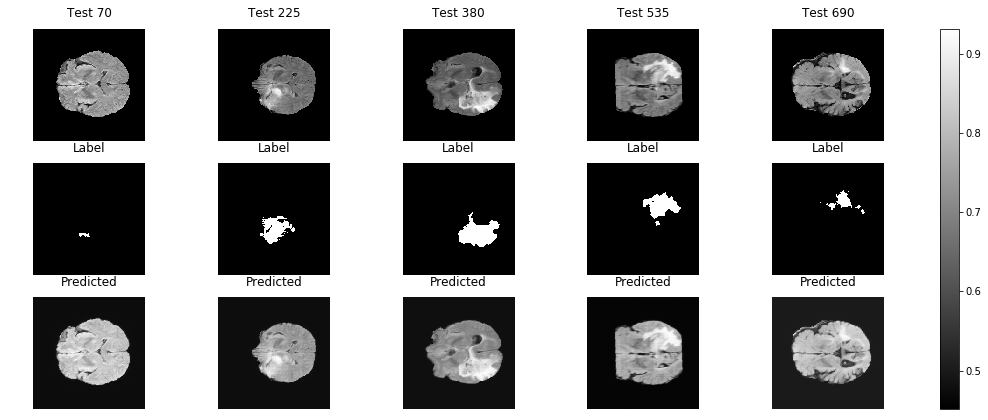

[2|20] Cost : 0.016229033        Epoch Time : 7.0 min


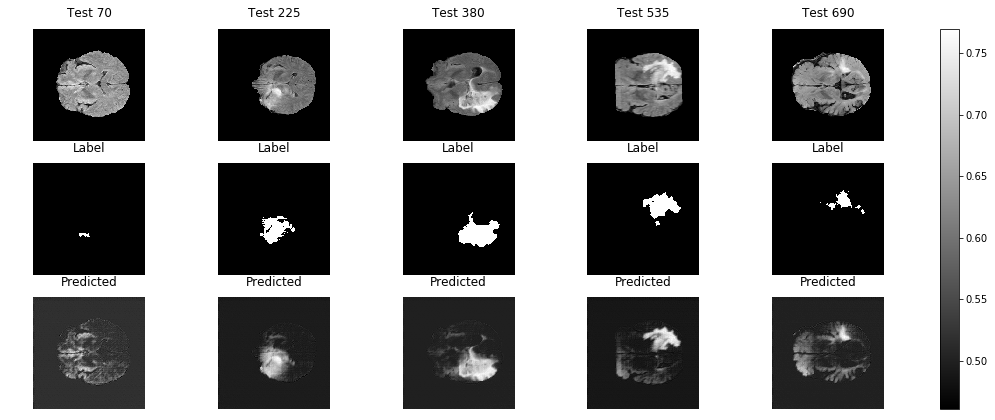

[4|20] Cost : 0.008387566        Epoch Time : 7.0 min


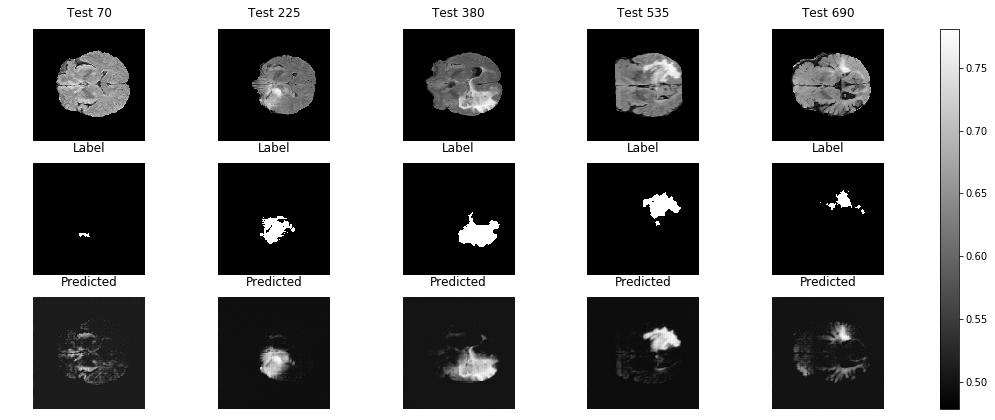

[6|20] Cost : 0.02152574        Epoch Time : 7.0 min


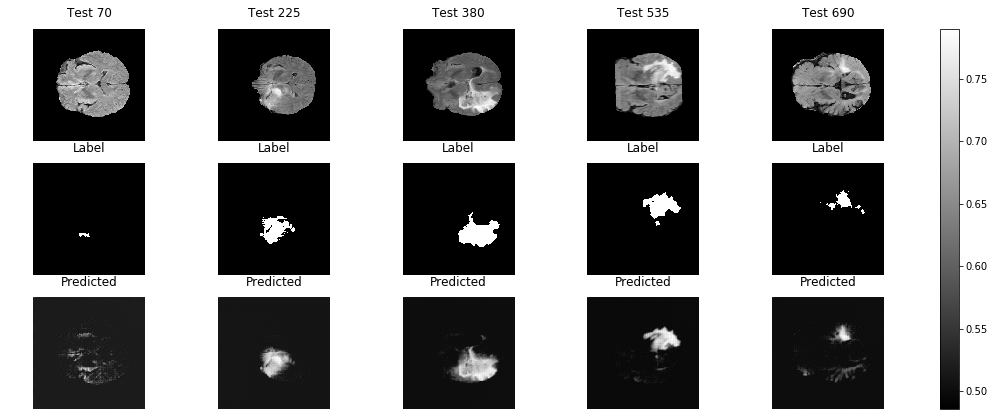

[8|20] Cost : 0.031008482        Epoch Time : 7.0 min


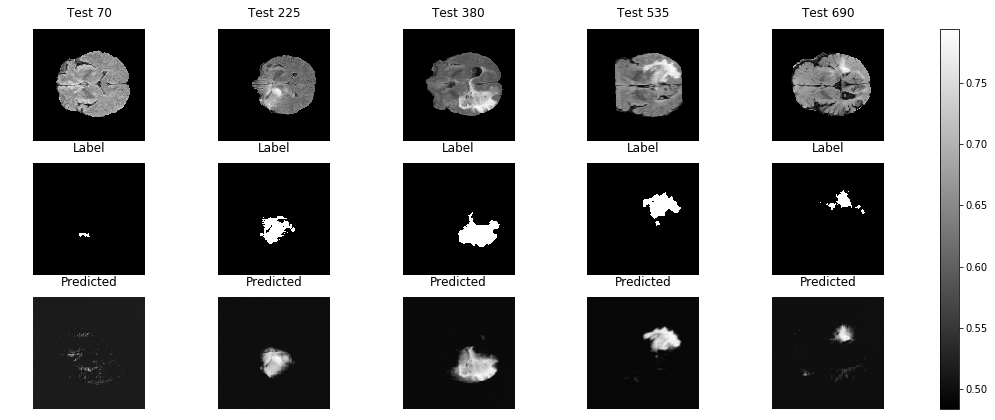

[10|20] Cost : 0.027899683        Epoch Time : 7.0 min


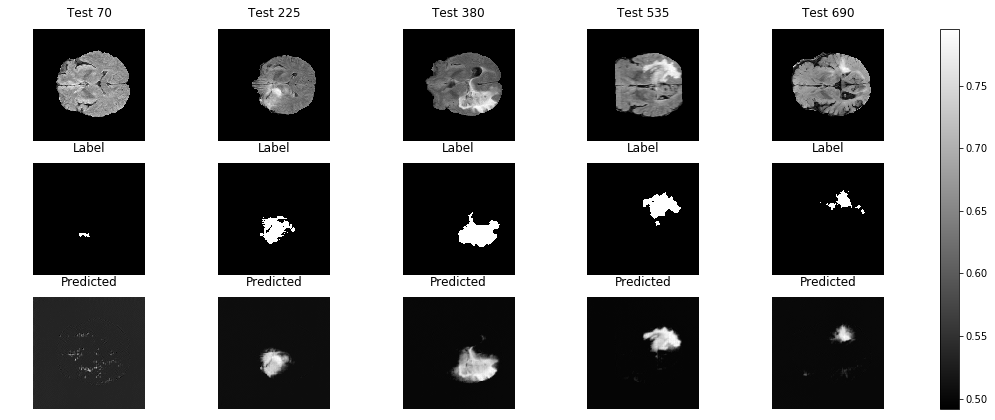

[12|20] Cost : 0.03382802        Epoch Time : 7.0 min


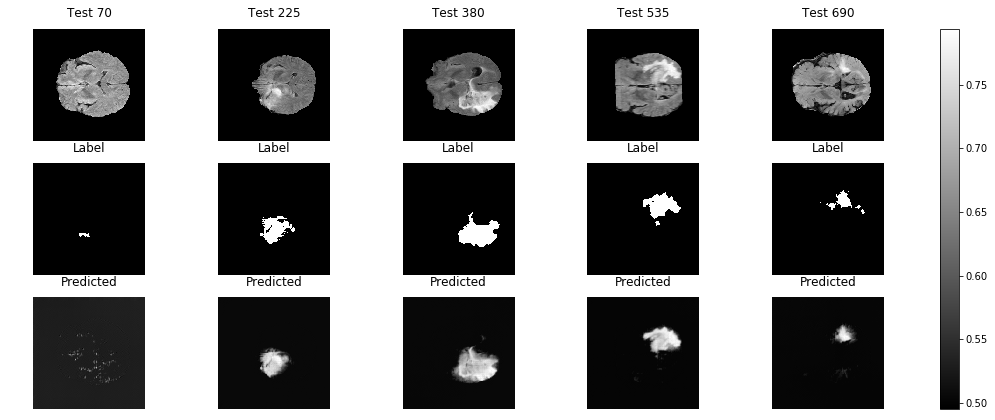

[14|20] Cost : 0.034977794        Epoch Time : 7.0 min


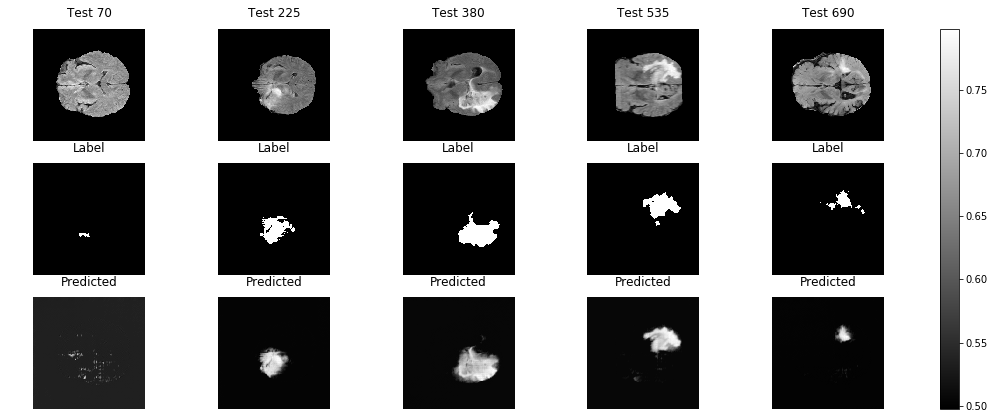

[16|20] Cost : 0.04156339        Epoch Time : 7.0 min


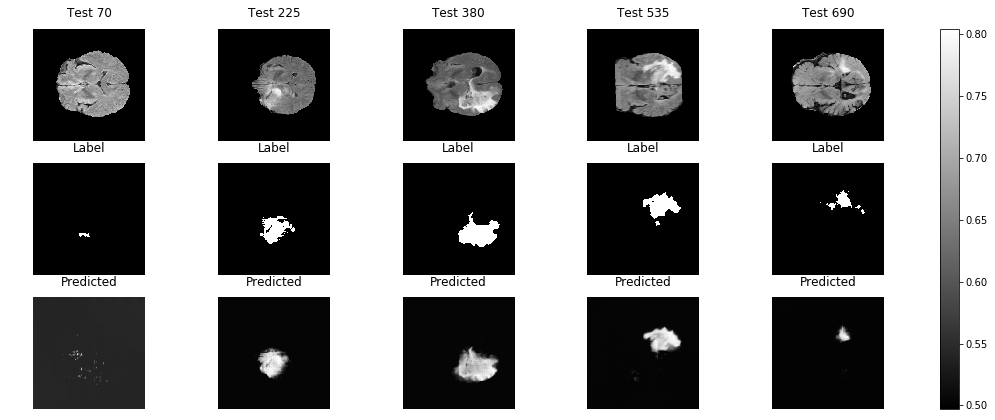

[18|20] Cost : 0.032813013        Epoch Time : 7.0 min


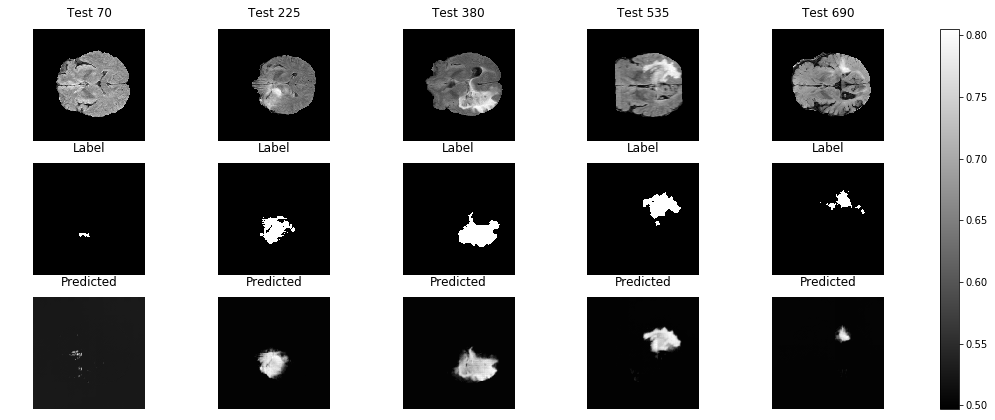

Training Time : 70.23594523333331 min


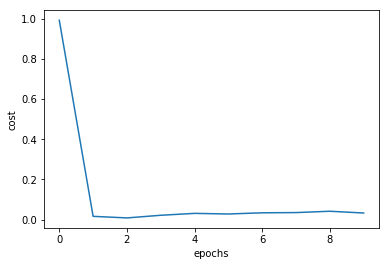

In [58]:
parameters = model(hdf5_data_file, hdf5_mask_file, num_epochs = 20 , minibatch_size = 1, learning_rate = 1e-4)

**Tensorboard** <br>
Since we are connecting remotely to the server:
1. ssh -L 16006:127.0.0.1:6006 user@server
2. source virtualenv_python3_for…./bin/activate
3. tensorboard --logdir=/path/to/logs
4. go to [localhost:16006/](https://localhost:16006/)

Each run will have a separate folder and they can be visualized simultaneously for comparison


# 8. Prediction

Load the model created during training and load a new image to make a prediction:

In [66]:
def get_mask():
    #X_test = np.zeros([155, 240, 240, 1])
    X_test = np.array(hdf5_data_file["test_data"][:,:,:,:])
    #Y_test = np.zeros([155, 240, 240, 2])
    Y_test = np.array(hdf5_mask_file["test_mask"][:,:,:,:])  

    print(X_test.shape)
    print(Y_test.shape)

    new_predictions = np.zeros([X_test.shape[0], 240, 240, 2])

    #Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        #load the graph and restore the weights
        saver = tf.train.import_meta_graph('checkpoints/3_flair_convnet-deep-1000.meta')
        saver.restore(sess, tf.train.latest_checkpoint('./checkpoints/'))

        #create placeholders 
        graph = tf.get_default_graph()
        X = graph.get_tensor_by_name("X_placeholder:0")
        Y = graph.get_tensor_by_name("Y_placeholder:0")
        prediction = graph.get_tensor_by_name("prediction:0")

        # test in the first patient
        for j in range(0, X_test.shape[0]):
            X_current = np.zeros([1, 240, 240, 1])
            X_current[:,:,:,:] = X_test[j,:,:,:]
            Y_current = np.zeros([1, 240, 240, 2])
            Y_current[:,:,:,:] = Y_test[j,:,:,:]
            feed_dict = {X:X_current, Y:Y_current}
            new_predictions[j,:,:,:] = sess.run( prediction, feed_dict=feed_dict)
            
    return  X_test, Y_test, new_predictions  

X_test, Y_test, new_predictions = get_mask()    

(1240, 240, 240, 1)
(1240, 240, 240, 2)
INFO:tensorflow:Restoring parameters from ./checkpoints/3_flair_convnet-deep-1000


<IPython.core.display.Javascript object>


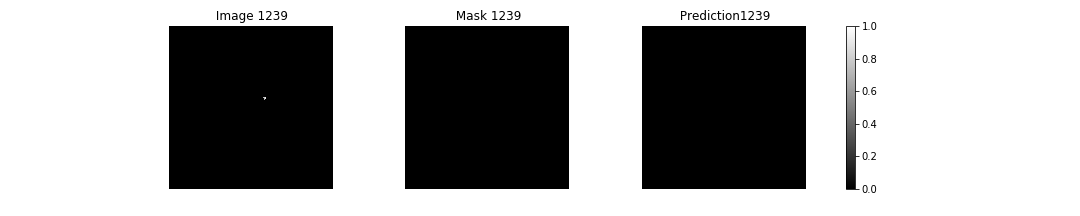

<IPython.core.display.Javascript object>


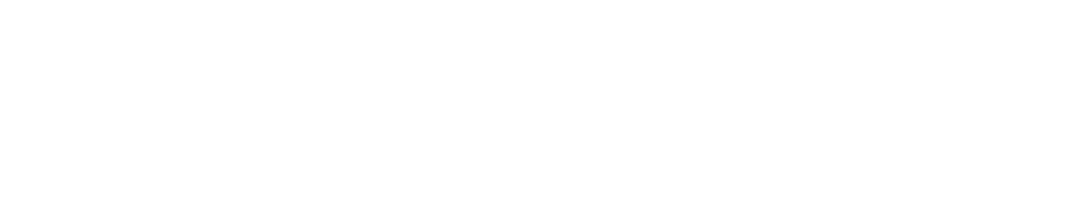

In [67]:
###======================== SHOW DATA ===================================###
%matplotlib notebook 
fig, ax = plt.subplots(ncols = 3, figsize=(15,3))

img3 = ax[2].imshow(hdf5_mask_file[mask_name][0,:,:,1], vmin=0, vmax=1, cmap=plt.get_cmap('gray'))
plt.colorbar(img3, ax=ax)

for h in range(0, X_test.shape[0]):
    img1 = ax[0].imshow(X_test[h,:,:,0], vmin=0, vmax=1, cmap=plt.get_cmap('gray'))
    ax[0].set_title(" Image " + str(h))
    ax[0].axis('off')

    img2 = ax[1].imshow(Y_test[h,:,:,1], vmin=0, vmax=1, cmap=plt.get_cmap('gray'))
    ax[1].set_title(" Mask "  + str(h))
    ax[1].axis('off')

    img3 = ax[2].imshow(new_predictions[h,:,:,1]>0.7, vmin=0, vmax=1,  cmap=plt.get_cmap('gray'))#
    ax[2].set_title(" Prediction"  + str(h))
    ax[2].axis('off')
    #plt.show()
    fig.canvas.draw()

    sleep(0.1)


## Close session and files

In [ ]:
hdf5_data_file.close()
hdf5_mask_file.close()

## Apendix